# 🤖 Mushroom Classification – Model Training


This notebook trains a neural network for mushroom edibility prediction.

1. Load and preprocess data
2. Create train/val/test splits
3. Build a neural network model
4. Train the model
5. Evaluate performance
6. Save the model for production use

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Visualization settings
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")

✅ Libraries imported successfully!
TensorFlow version: 2.16.1
GPU available: False


## 1. Load and Prepare Data

In [2]:
# Load data
print("📁 Loading data...")
df = pd.read_csv('../dataset/secondary_data.csv', delimiter=';')

# Clean column names
df.columns = df.columns.str.lower().str.replace('-', '_')

print(f"✅ Loaded {len(df):,} samples with {len(df.columns)} columns")
print(f"\nDataset shape: {df.shape}")
df.head()

📁 Loading data...
✅ Loaded 61,069 samples with 21 columns

Dataset shape: (61069, 21)


,class,cap_diameter,cap_shape,cap_surface,cap_color,does_bruise_or_bleed,gill_attachment,gill_spacing,gill_color,stem_height,...,stem_root,stem_surface,stem_color,veil_type,veil_color,has_ring,ring_type,spore_print_color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,...,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,...,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,...,s,y,w,u,w,t,p,NaN,d,w


In [3]:
# Check class distribution
print("\n🎯 Class Distribution:")
print(df['class'].value_counts())
print(f"\nEdible: {(df['class'] == 'e').sum():,}")
print(f"Poisonous: {(df['class'] == 'p').sum():,}")


🎯 Class Distribution:
class
p    33888
e    27181
Name: count, dtype: int64

Edible: 27,181
Poisonous: 33,888


## 2. Prepare Features and Target

In [4]:
# Separate features and target
feature_cols = [
    'cap_diameter', 'cap_shape', 'cap_surface', 'cap_color',
    'does_bruise_or_bleed', 'gill_attachment', 'gill_spacing', 'gill_color',
    'stem_height', 'stem_width', 'stem_root', 'stem_surface', 'stem_color',
    'veil_type', 'veil_color', 'has_ring', 'ring_type',
    'spore_print_color', 'habitat', 'season'
]

X = df[feature_cols].copy()
y = df['class'].copy()

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures: {list(X.columns)}")

Features shape: (61069, 20)
Target shape: (61069,)

Features: ['cap_diameter', 'cap_shape', 'cap_surface', 'cap_color', 'does_bruise_or_bleed', 'gill_attachment', 'gill_spacing', 'gill_color', 'stem_height', 'stem_width', 'stem_root', 'stem_surface', 'stem_color', 'veil_type', 'veil_color', 'has_ring', 'ring_type', 'spore_print_color', 'habitat', 'season']


## 3. Preprocessing

In [5]:
# Identify numerical and categorical features
numerical_cols = ['cap_diameter', 'stem_height', 'stem_width']
categorical_cols = [col for col in X.columns if col not in numerical_cols]

print(f"Numerical features ({len(numerical_cols)}): {numerical_cols}")
print(f"Categorical features ({len(categorical_cols)}): {categorical_cols}")

Numerical features (3): ['cap_diameter', 'stem_height', 'stem_width']
Categorical features (17): ['cap_shape', 'cap_surface', 'cap_color', 'does_bruise_or_bleed', 'gill_attachment', 'gill_spacing', 'gill_color', 'stem_root', 'stem_surface', 'stem_color', 'veil_type', 'veil_color', 'has_ring', 'ring_type', 'spore_print_color', 'habitat', 'season']


In [6]:
# Create encoders
print("\n🔧 Creating preprocessors...")

# OneHotEncoder for categorical features
onehot_encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
categorical_encoded = onehot_encoder.fit_transform(X[categorical_cols])

# StandardScaler for numerical features
scaler = StandardScaler()
numerical_scaled = scaler.fit_transform(X[numerical_cols])

# Combine features
X_processed = np.hstack([numerical_scaled, categorical_encoded])

# Encode target (p=1, e=0)
y_encoded = (y == 'p').astype(int).values

print(f"\n✅ Preprocessing complete!")
print(f"Original features: {X.shape[1]}")
print(f"Processed features: {X_processed.shape[1]}")
print(f"Target encoded: {y_encoded.shape}")


🔧 Creating preprocessors...

✅ Preprocessing complete!
Original features: 20
Processed features: 111
Target encoded: (61069,)


## 4. Train/Val/Test Split

In [7]:
# First split: separate test set
X_temp, X_test, y_temp, y_test = train_test_split(
    X_processed, y_encoded,
    test_size=0.15,
    random_state=RANDOM_SEED,
    stratify=y_encoded
)

# Second split: separate validation from training
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.15 / 0.85,  # 15% of original data
    random_state=RANDOM_SEED,
    stratify=y_temp
)

print("\n🔀 Data Split:")
print("=" * 60)
print(f"Train set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X_processed)*100:.1f}%)")
print(f"Val set:   {X_val.shape[0]:,} samples ({X_val.shape[0]/len(X_processed)*100:.1f}%)")
print(f"Test set:  {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X_processed)*100:.1f}%)")
print(f"\nTotal: {X_train.shape[0] + X_val.shape[0] + X_test.shape[0]:,} samples")


🔀 Data Split:
Train set: 42,747 samples (70.0%)
Val set:   9,161 samples (15.0%)
Test set:  9,161 samples (15.0%)

Total: 61,069 samples


## 5. Build Neural Network Model

In [8]:
# Create model
print("🏗️  Building model...\n")

input_shape = X_train.shape[1]

model = keras.Sequential([
    # Input layer
    layers.Input(shape=(input_shape,)),
    
    # Hidden layers
    layers.Dense(256, activation='relu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(32, activation='relu', kernel_initializer='he_normal'),
    layers.Dropout(0.2),
    
    # Output layer
    layers.Dense(1, activation='sigmoid')
], name='mushroom_classifier')

# Compile model
model.compile(
    optimizer=keras.optimizers.Nadam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')
    ]
)

print("✅ Model created!\n")
model.summary()

🏗️  Building model...

✅ Model created!



Model: "mushroom_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        28,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,729 (288.00 KB)

 Trainable params: 72,833 (284.50 KB)

 Non-trainable params: 896 (3.50 KB)

## 6. Train Model

In [9]:
# Setup - callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]

print("✅ Callbacks configured")

✅ Callbacks configured


In [10]:
# Train model
print("\n🎯 Training model...\n")

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Training complete!")


🎯 Training model...

Epoch 1/50
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9060 - loss: 0.2098 - precision: 0.9203 - recall: 0.9094 - val_accuracy: 0.9990 - val_loss: 0.0040 - val_precision: 0.9984 - val_recall: 0.9998 - learning_rate: 0.0010
Epoch 2/50
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9883 - loss: 0.0347 - precision: 0.9888 - recall: 0.9901 - val_accuracy: 0.9988 - val_loss: 0.0027 - val_precision: 0.9986 - val_recall: 0.9992 - learning_rate: 0.0010
Epoch 3/50
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9914 - loss: 0.0243 - precision: 0.9918 - recall: 0.9926 - val_accuracy: 0.9992 - val_loss: 0.0015 - val_precision: 0.9986 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/50
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9943 - loss: 0.0178 - precision: 0.9949 - recall: 0.9949 - val_accuracy: 1.0000 - val_loss: 4.1531e-04 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 5/50
1336/1336 ━━━━━━━━━

## 7. Visualize Training History

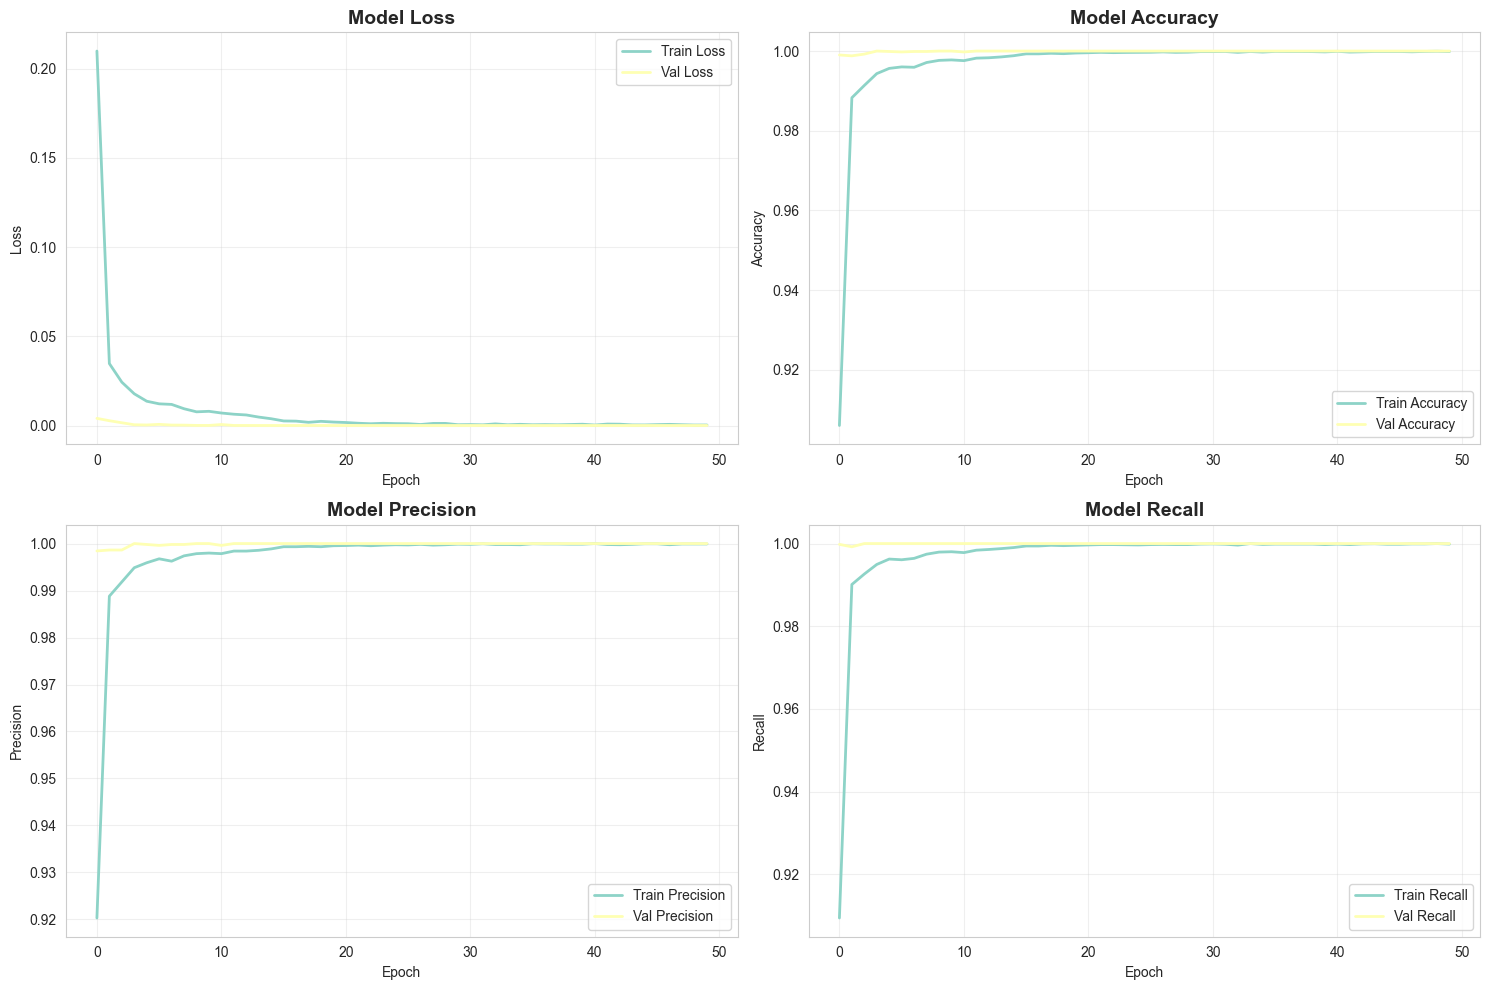

In [11]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 0].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0, 1].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0, 1].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Precision
axes[1, 0].plot(history.history['precision'], label='Train Precision', linewidth=2)
axes[1, 0].plot(history.history['val_precision'], label='Val Precision', linewidth=2)
axes[1, 0].set_title('Model Precision', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Recall
axes[1, 1].plot(history.history['recall'], label='Train Recall', linewidth=2)
axes[1, 1].plot(history.history['val_recall'], label='Val Recall', linewidth=2)
axes[1, 1].set_title('Model Recall', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Evaluate on Test Set

In [12]:
# Evaluate on the test set
print("📊 Evaluating on test set...\n")
test_results = model.evaluate(X_test, y_test, verbose=0)

print("=" * 70)
print(" TEST SET RESULTS")
print("=" * 70)
print(f"Loss:      {test_results[0]:.6f}")
print(f"Accuracy:  {test_results[1]:.4f} ({test_results[1]*100:.2f}%)")
print(f"Precision: {test_results[2]:.4f}")
print(f"Recall:    {test_results[3]:.4f}")
print("=" * 70)

📊 Evaluating on test set...

 TEST SET RESULTS
Loss:      0.000000
Accuracy:  1.0000 (100.00%)
Precision: 1.0000
Recall:    1.0000


In [13]:
# Make predictions on the test set
y_pred_prob = model.predict(X_test, verbose=0)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

print(f"Predictions generated: {len(y_pred)}")

Predictions generated: 9161


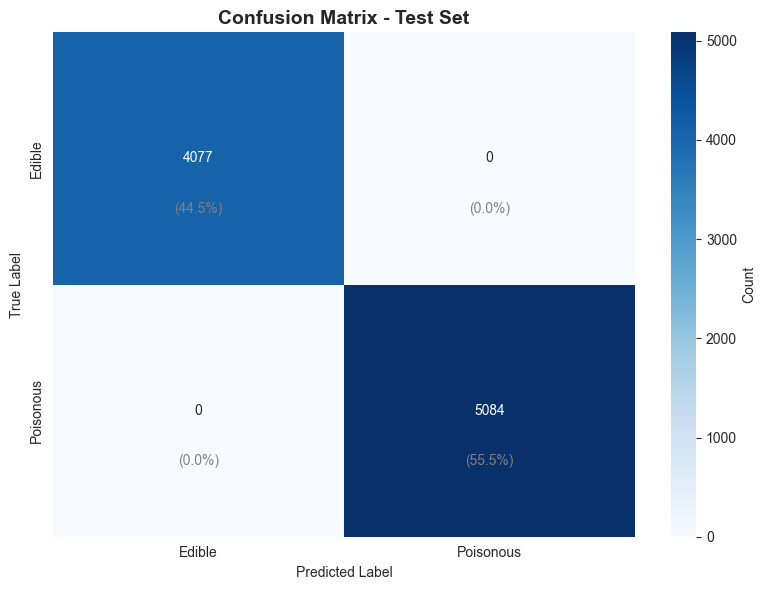


📋 Classification Report:
              precision    recall  f1-score   support

      Edible     1.0000    1.0000    1.0000      4077
   Poisonous     1.0000    1.0000    1.0000      5084

    accuracy                         1.0000      9161
   macro avg     1.0000    1.0000    1.0000      9161
weighted avg     1.0000    1.0000    1.0000      9161



In [14]:
# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'},
            xticklabels=['Edible', 'Poisonous'],
            yticklabels=['Edible', 'Poisonous'])
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Add percentage annotations
for i in range(2):
    for j in range(2):
        pct = cm[i, j] / cm.sum() * 100
        plt.text(j+0.5, i+0.7, f'({pct:.1f}%)', 
                ha='center', va='center', fontsize=10, color='gray')

plt.tight_layout()
plt.show()

print("\n📋 Classification Report:")
print("=" * 70)
print(classification_report(y_test, y_pred, target_names=['Edible', 'Poisonous'], digits=4))

## 9. Test Prediction on Sample Data

In [15]:
# Test on a random sample
sample_idx = np.random.randint(0, len(X_test))
sample_X = X_test[sample_idx:sample_idx+1]
sample_y_true = y_test[sample_idx]

# Predict
pred_prob = model.predict(sample_X, verbose=0)[0][0]
pred_class = 'Poisonous' if pred_prob > 0.5 else 'Edible'
true_class = 'Poisonous' if sample_y_true == 1 else 'Edible'
confidence = max(pred_prob, 1 - pred_prob) * 100

print("\n🧪 Sample Prediction Test:")
print("=" * 70)
print(f"True Label:        {true_class}")
print(f"Predicted Label:   {pred_class}")
print(f"Confidence:        {confidence:.2f}%")
print(f"Raw Probability:   {pred_prob:.4f} (probability of being poisonous)")
print(f"\nResult: {'✅ CORRECT' if (pred_class == true_class) else '❌ WRONG'}")
print("=" * 70)


🧪 Sample Prediction Test:
True Label:        Poisonous
Predicted Label:   Poisonous
Confidence:        100.00%
Raw Probability:   1.0000 (probability of being poisonous)

Result: ✅ CORRECT


## 10. Save Model and Preprocessors

In [19]:
# Create a directory for saved models
model_dir = '../models_saved/nb'
os.makedirs(model_dir, exist_ok=True)

# Save the model
model_path = os.path.join(model_dir, 'mushroom_classifier.h5')
model.save(model_path)
print(f"✅ Model saved to: {model_path}")

# Save the encoders and scaler
with open(os.path.join(model_dir, 'onehot_encoder.pkl'), 'wb') as f:
    pickle.dump(onehot_encoder, f)
    
with open(os.path.join(model_dir, 'scaler.pkl'), 'wb') as f:
    pickle.dump(scaler, f)
    
# Save feature names for reference
with open(os.path.join(model_dir, 'feature_info.pkl'), 'wb') as f:
    pickle.dump({
        'numerical_cols': numerical_cols,
        'categorical_cols': categorical_cols,
        'all_features': feature_cols
    }, f)

print(f"✅ Preprocessors saved to: {model_dir}")
print("\n📦 Saved files:")
print(f"  - mushroom_classifier.h5  (Model)")
print(f"  - onehot_encoder.pkl      (Categorical encoder)")
print(f"  - scaler.pkl              (Numerical scaler)")
print(f"  - feature_info.pkl        (Feature metadata)")

✅ Model saved to: ../models_saved/nb\mushroom_classifier.h5
✅ Preprocessors saved to: ../models_saved/nb

📦 Saved files:
  - mushroom_classifier.h5  (Model)
  - onehot_encoder.pkl      (Categorical encoder)
  - scaler.pkl              (Numerical scaler)
  - feature_info.pkl        (Feature metadata)


## 11. Model Summary

In [20]:
print("\n" + "=" * 70)
print(" TRAINING COMPLETE - MODEL SUMMARY")
print("=" * 70)
print(f"\n📊 Dataset:")
print(f"  Total samples:     {len(df):,}")
print(f"  Training samples:  {len(X_train):,}")
print(f"  Validation samples: {len(X_val):,}")
print(f"  Test samples:      {len(X_test):,}")

print(f"\n🏗️  Model Architecture:")
print(f"  Input features:    {X_train.shape[1]}")
print(f"  Hidden layers:     4 (256 → 128 → 64 → 32)")
print(f"  Output:            Binary (Edible/Poisonous)")
print(f"  Total parameters:  {model.count_params():,}")

print(f"\n📈 Performance (Test Set):")
print(f"  Accuracy:          {test_results[1]*100:.2f}%")
print(f"  Precision:         {test_results[2]:.4f}")
print(f"  Recall:            {test_results[3]:.4f}")
print(f"  Loss:              {test_results[0]:.6f}")

print(f"\n💾 Saved To:")
print(f"  Directory:         {model_dir}")

print("=" * 70)


 TRAINING COMPLETE - MODEL SUMMARY

📊 Dataset:
  Total samples:     61,069
  Training samples:  42,747
  Validation samples: 9,161
  Test samples:      9,161

🏗️  Model Architecture:
  Input features:    111
  Hidden layers:     4 (256 → 128 → 64 → 32)
  Output:            Binary (Edible/Poisonous)
  Total parameters:  73,729

📈 Performance (Test Set):
  Accuracy:          100.00%
  Precision:         1.0000
  Recall:            1.0000
  Loss:              0.000000

💾 Saved To:
  Directory:         ../models_saved/nb
